# SARIMAX
Basically a SARIMA model while also including the effect of external variables for future predictions, also called as exogenous variables, X.

## Exploring the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [6]:
macro_econ_data.year.describe()

count     203.000000
mean     1983.876847
std        14.686817
min      1959.000000
25%      1971.000000
50%      1984.000000
75%      1996.500000
max      2009.000000
Name: year, dtype: float64

In [7]:
macro_econ_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


* We know that realgdp (GDP) is our endogenous variable.
* For the sake of simplicity, we consider only the variables from 3.realcons to 7.cpi as our exogenous variables.
* Now we can visualize these variables.

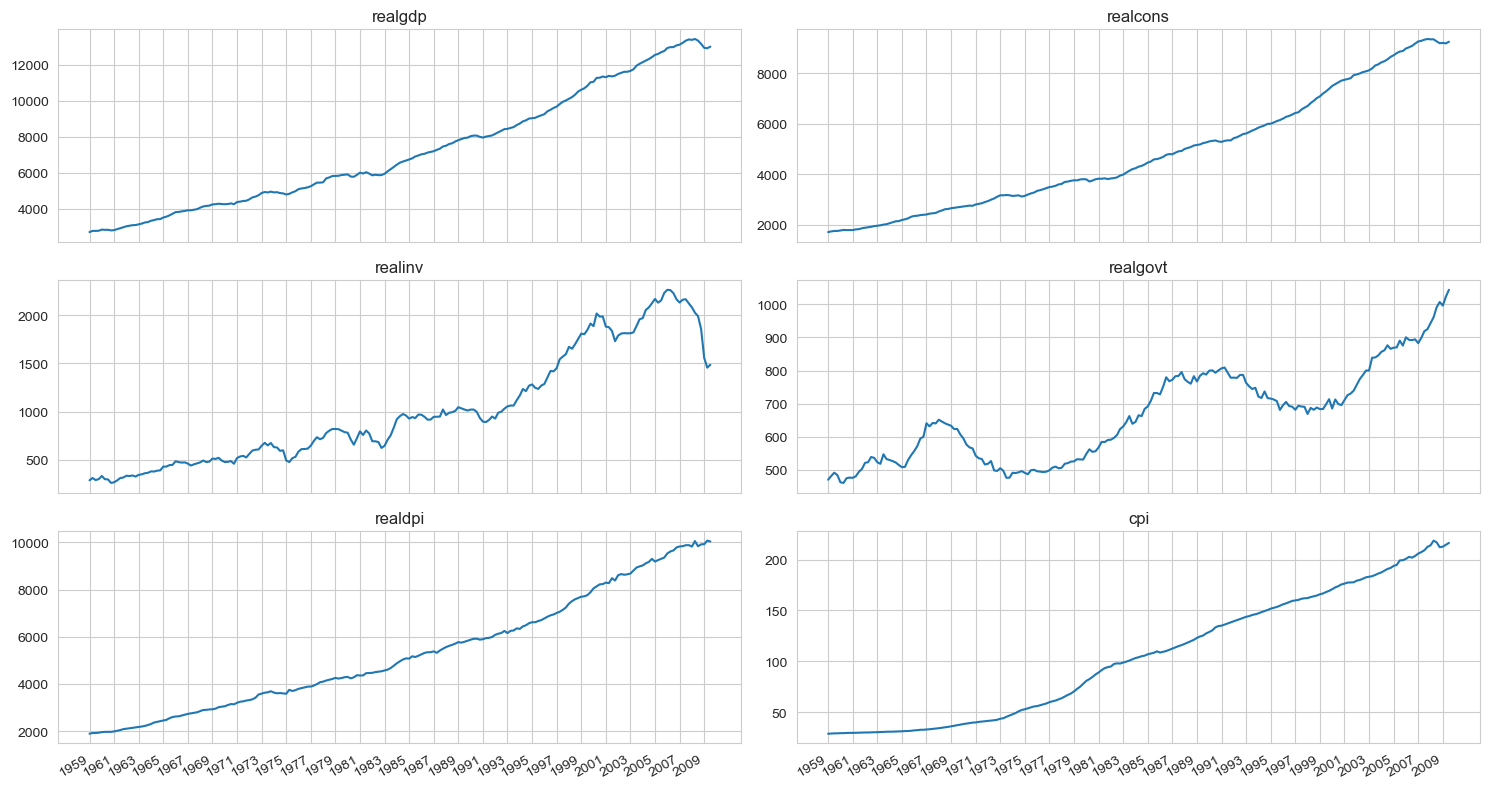

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

for i, ax in enumerate(axs.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i + 2]]

    ax.plot(data)
    ax.set_title(macro_econ_data.columns[i + 2])
    
plt.setp(axs, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

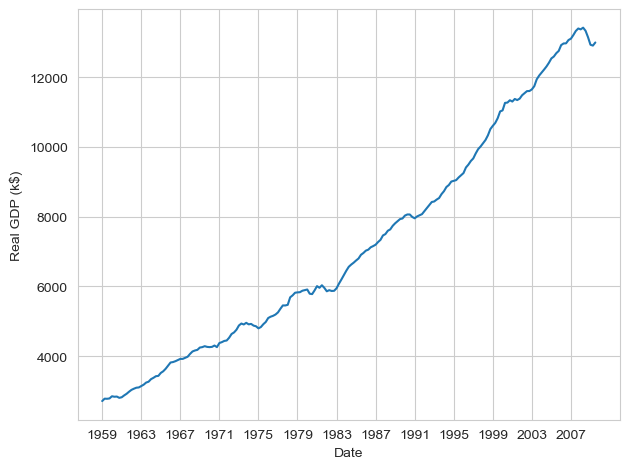

In [9]:
plt.plot(macro_econ_data['realgdp'])
plt.xlabel('Date')
plt.ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[macro_econ_data.columns[3:8]]

In [11]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  203 non-null    float64
 1   realinv   203 non-null    float64
 2   realgovt  203 non-null    float64
 3   realdpi   203 non-null    float64
 4   cpi       203 non-null    float64
dtypes: float64(5)
memory usage: 8.1 KB


## Checking for stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller
ADF = adfuller(target)
print("ADF Statistic = {}".format(ADF[0]))
print("p-value = {}".format(ADF[1]))

ADF Statistic = 1.7504627967647106
p-value = 0.9982455372335032


* As we can see our data is not stationary.
* So, we have to go for differencing to make it stationary.

In [13]:
target_diff = target.diff()
target_diff

0          NaN
1       68.452
2       -3.313
3        9.716
4       62.495
        ...   
198    -90.666
199   -182.680
200   -216.510
201    -23.906
202     88.837
Name: realgdp, Length: 203, dtype: float64

In [14]:
ADF_diff = adfuller(target_diff[1:])
print("ADF Statistic = {}".format(ADF_diff[0]))
print("p-value = {}".format(ADF_diff[1]))

ADF Statistic = -6.305695561658104
p-value = 3.327882187668259e-08


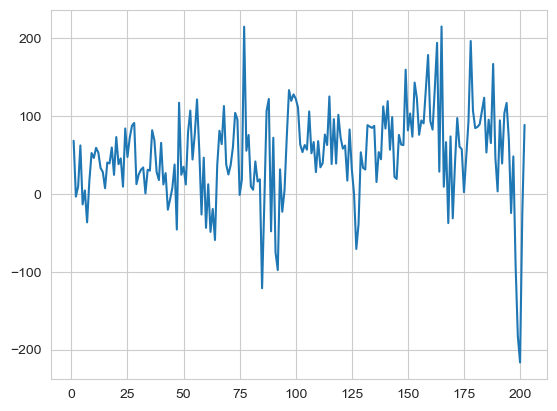

In [15]:
plt.plot(target_diff[1:])

* As we can see the data becomes stationary after first order differencing.
* So, d=1.
* Now as we do not need to take seasonal difference, then D=0. 

## Selecting the SARIMAX model

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(parameter_list, exog, endog, d, D, m) -> pd.DataFrame:
    """This function gets the list of all p, q, P, Q values and the d, D values, creates the model for each of the (p, d, q)(P, D, Q) values and then finds the AIC value of each of the model and 
    displays the output as a dataframe in ascending order of AIC values"""
    result = []
    for p, q, sP, sQ in parameter_list:
        model = SARIMAX(endog, exog, order=(p, d, q), seasonal_order=(sP, D, sQ, m), simple_differencing=False).fit(disp=False)
        aic = model.aic
        result.append([(p, q, sP, sQ), aic])
    result_df = pd.DataFrame(result)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    # Sorting in ascending order
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [17]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
m = 4

* As the data is collected quarterly, we assign m=4.

In [18]:
from itertools import product

parameters_list = list(product(p, q, P, Q))

* We split the data as training and testing.
* We do this for both the endogenous and exogenous variables.

In [23]:
target_train = target[:200]
exog_train = exog[:200]

In [ ]:
result_df = optimize_SARIMAX(parameters_list, exog_train, target_train, d, D, m)

* As the above takes a long time to compute the expected output is as follows;
<br><br>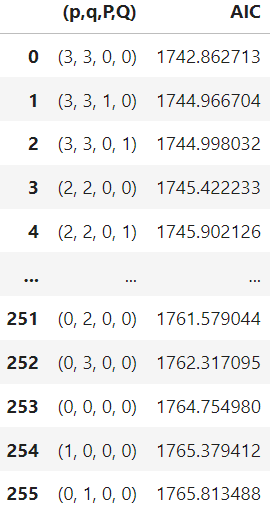

* So we can see that the best model is SARIMAX(3, 1, 3)(0, 0, 0, 4).
* Here we can see that there is no seasonal component.
* This makes sense, as when we observe the GDP plot there seems to be no seasonality in the data.

In [24]:
model = SARIMAX(endog=target_train, exog=exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Tue, 28 Mar 2023   AIC                           1742.824
Time:                        20:58:50   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.509      0.000       0.882       1.059
realinv        1.0132      0.033     30.696      0.000       0.949       1.078
realgovt       0.7282      0.127      5.728      0.0

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Residual Analysis

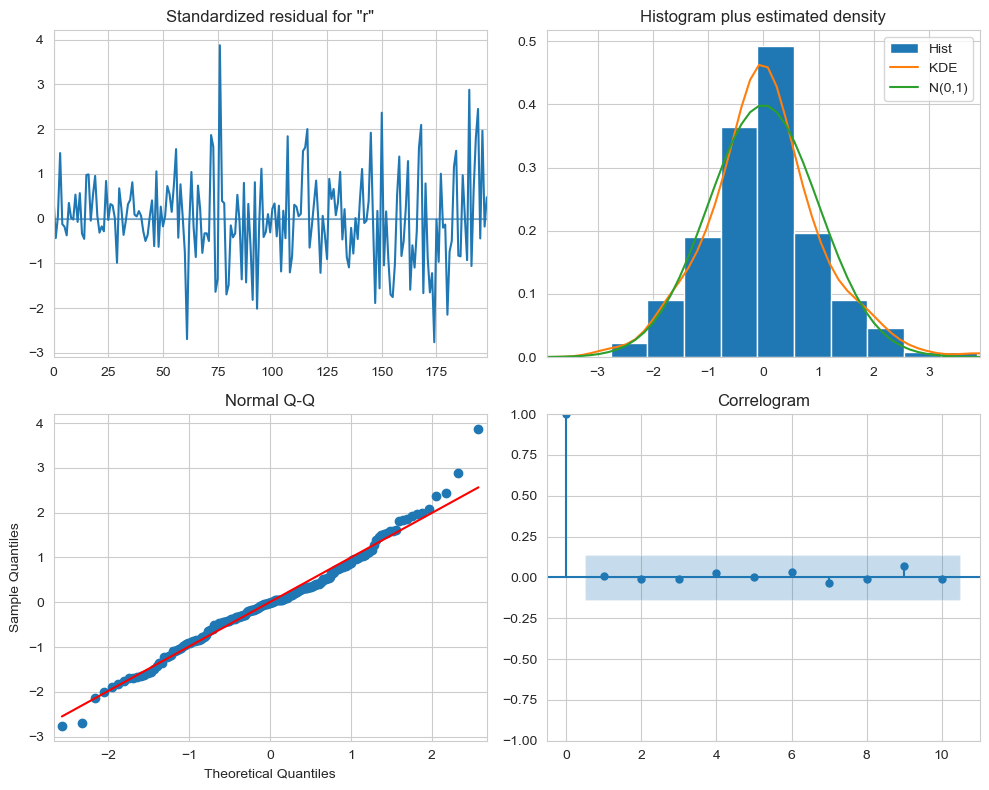

In [25]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

* All the plots satisfy our requirements.

In [26]:
residuals = model_fit.resid

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(residuals, np.arange(1, 11, 1)) # the arrange specifies the lags upto which we are testing, here we are testing the first 10 lags
ljung['lb_pvalue']

1     0.761255
2     0.905242
3     0.977399
4     0.868671
5     0.939240
6     0.972498
7     0.983112
8     0.992930
9     0.993511
10    0.997272
Name: lb_pvalue, dtype: float64

* All the p-values are > 0.05 thus the residuals are uncorrelated.

## Model Predictions

* We have trained the model till 2008, we are going to preidct for 2009.

In [38]:
pred = model_fit.get_prediction(exog=exog[-1:])

In [39]:
pred.predicted_mean

0       2479.832201
1       2769.701331
2       2784.298994
3       2784.125737
4       2819.463826
           ...     
195    13346.667554
196    13374.934728
197    13379.551728
198    13327.859690
199    13133.238510
Name: predicted_mean, Length: 200, dtype: float64

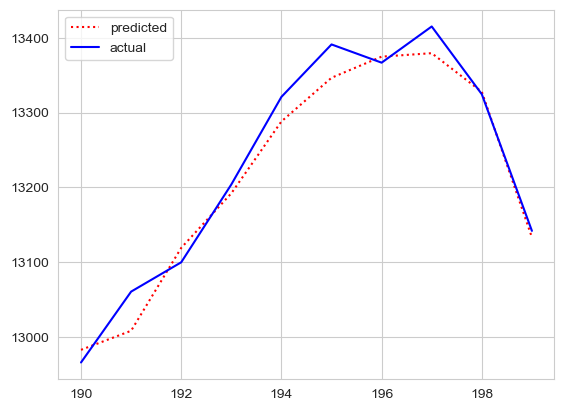

In [48]:
plt.plot(pred.predicted_mean[-10:], 'r:', label='predicted')
plt.plot(target_train[-10:], 'b-', label='actual')
plt.legend()